# Converting a Segmentation Model via CoreML

### Imports

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import urllib
import torch
import torch.nn as nn
import torchvision
import json

from torchvision import transforms
from coremltools.converters import convert
from coremltools.models import MLModel
from PIL import Image

### Load Sample Model

In [4]:
# Load model
model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True).eval()

Using cache found in /Users/paul_curry/.cache/torch/hub/pytorch_vision_v0.6.0


### Load Sample Image

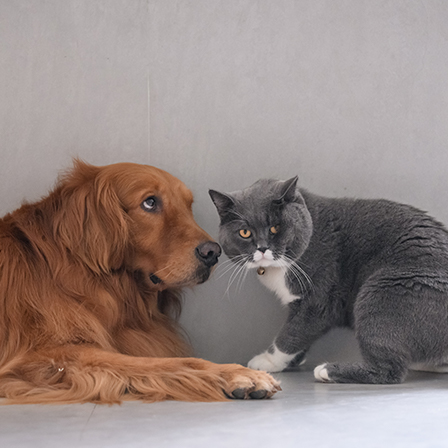

In [5]:
input_image = Image.open("dog_and_cat.jpg")
display(input_image)

### Image Preprocessing

In [6]:
# Preprocess image
to_tensor = transforms.ToTensor()
input_tensor = to_tensor(input_image)
print(input_tensor.shape)
input_batch = input_tensor.unsqueeze(0)

torch.Size([3, 448, 448])


### Trace the Model with PyTorch

In [7]:
# First attempt at tracing
trace = torch.jit.trace(model, input_batch)

RuntimeError: Only tensors or tuples of tensors can be output from traced functions (getOutput at ../torch/csrc/jit/tracer.cpp:212)
frame #0: c10::Error::Error(c10::SourceLocation, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&) + 135 (0x10c1ec787 in libc10.dylib)
frame #1: torch::jit::tracer::TracingState::getOutput(c10::IValue const&, unsigned long) + 1587 (0x11d8502d3 in libtorch.dylib)
frame #2: torch::jit::tracer::trace(std::__1::vector<c10::IValue, std::__1::allocator<c10::IValue> >, std::__1::function<std::__1::vector<c10::IValue, std::__1::allocator<c10::IValue> > (std::__1::vector<c10::IValue, std::__1::allocator<c10::IValue> >)> const&, std::__1::function<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > (at::Tensor const&)>, bool, torch::jit::script::Module*) + 1865 (0x11d850ee9 in libtorch.dylib)
frame #3: torch::jit::tracer::createGraphByTracing(pybind11::function const&, std::__1::vector<c10::IValue, std::__1::allocator<c10::IValue> >, pybind11::function const&, bool, torch::jit::script::Module*) + 361 (0x10b7daa49 in libtorch_python.dylib)
frame #4: void pybind11::cpp_function::initialize<torch::jit::script::initJitScriptBindings(_object*)::$_13, void, torch::jit::script::Module&, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&, pybind11::function, pybind11::tuple, pybind11::function, bool, pybind11::name, pybind11::is_method, pybind11::sibling>(torch::jit::script::initJitScriptBindings(_object*)::$_13&&, void (*)(torch::jit::script::Module&, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&, pybind11::function, pybind11::tuple, pybind11::function, bool), pybind11::name const&, pybind11::is_method const&, pybind11::sibling const&)::'lambda'(pybind11::detail::function_call&)::__invoke(pybind11::detail::function_call&) + 319 (0x10b81bd9f in libtorch_python.dylib)
frame #5: pybind11::cpp_function::dispatcher(_object*, _object*, _object*) + 3372 (0x10b14e9fc in libtorch_python.dylib)
<omitting python frames>


### Wrap the Model to Allow Tracing

In [11]:
class WrappedDeeplabv3Resnet101(nn.Module):

    input_shape = (1, 3, 512, 512)

    def __init__(self):
        super(WrappedDeeplabv3Resnet101, self).__init__()
        self.model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True).eval()

    def forward(self, x):
        res = self.model(x)
        x = res["out"]
        return x

### Trace the Wrapped Model

In [9]:
traceable_model = WrappedDeeplabv3Resnet101().eval()
trace = torch.jit.trace(traceable_model, input_batch)

Using cache found in /Users/paul_curry/.cache/torch/hub/pytorch_vision_v0.6.0


### Convert to Core ML 

In [10]:
mlmodel = convert(
    trace,
    inputs=[input_batch],
)

### Set the Model Metadata

In [18]:
labels_json = {"labels": ["background", "aeroplane", "bicycle", "bird", "board", "bottle", "bus", "car", "cat", "chair", "cow", "diningTable", "dog", "horse", "motorbike", "person", "pottedPlant", "sheep", "sofa", "train", "tvOrMonitor"]}

mlmodel.user_defined_metadata['com.apple.coreml.model.preview.type'] = 'imageSegmenter'
mlmodel.user_defined_metadata['com.apple.coreml.model.preview.params'] = json.dumps(labels_json)

### Save the Model for Visualization

In [19]:
mlmodel.save("converted_model.mlmodel")